# **Topic 7 – Dimensionality Reduction**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1bPn_DOTALUoQ24NwR411ZQjxgJR-rDFF#scrollTo=-yUvtsiq5nmJ)

# Setup

As we did in previous topics, let's define the default font sizes to make the figures prettier:

In [21]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/dim_reduction` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [23]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA

Let's generate a small 3D dataset. It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise:

In [1]:
# Data generation

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(1812)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [5]:
X.shape

(60, 3)

In [6]:
X

array([[-5.73786441e-01, -5.16623439e-01,  2.08278649e-01],
       [-2.22854585e-01, -8.09344243e-01, -1.64462984e-01],
       [ 9.47327200e-01,  6.02683854e-01,  1.03894528e-01],
       [ 5.73383614e-01,  1.29868585e+00,  5.74304581e-01],
       [ 1.55866861e-02, -6.83536734e-01, -3.30688759e-01],
       [-3.46465340e-01, -1.40161084e+00, -2.11658684e-01],
       [ 2.01885119e-01, -3.58896329e-01, -3.32090296e-01],
       [ 6.19523223e-01,  7.76822933e-02,  1.92095782e-01],
       [-6.23504261e-01, -6.73123454e-01,  3.32640610e-01],
       [-5.40586100e-01, -4.75224187e-02,  1.09313642e-01],
       [ 4.80083428e-01,  4.58611831e-01,  2.69029627e-01],
       [-7.87037720e-01, -8.14590272e-01,  1.18063567e-01],
       [-6.20838075e-01, -9.70772368e-01, -1.86294921e-01],
       [ 4.77506514e-01,  5.93859591e-01,  3.42550218e-01],
       [ 1.23248084e+00,  1.14423822e+00,  1.12741276e+00],
       [-7.58426239e-02, -7.78209413e-01,  1.55012831e-01],
       [-3.61417514e-01, -6.49636566e-01

## Principal Components

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # WE decide the number of components. In this case we only have three vars...
X2D = pca.fit_transform(X)

In [4]:
pca.components_

array([[ 0.58511015,  0.77656891,  0.23363826],
       [ 0.80172675, -0.59726292, -0.02261032]])

## Explained Variance Ratio

Now let's look at the explained variance ratio:

In [10]:
pca.explained_variance_ratio_

array([0.80143834, 0.11759627])

The first dimension explains about 80% of the variance, while the second explains about 12%. So, by projecting down to 2D, we lost about 8% of the variance.

## Choosing the Right Number of Dimensions

Instead of choosing the number of dimensions to reduce down to, it is possible to choose the proportion of variance aiming to capture. The algorithm will select the number of components that gathers it.

In [12]:
# Let's download the MNIST data and split them
from sklearn.datasets import fetch_openml

# Remember than in this specific case, it is not necesssary to split randomly. But you could of course do it if you'd like.
mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

c:\Users\javie\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Note that in X_train we count with 784 features.

Now we look for the number of components **that gather at least 95% of the variance**


In [13]:
# Now we look for the number of components that gather at least 95% of the variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [15]:
pca.n_components_

154

In [17]:
pca.explained_variance_ratio_.sum()

0.9501960192613033

To create a plot on how the variance is accumulated as the number of PC increase, we need to train again the PCA with all the components. Then we plot the values, as well as the one at 95% (we call it d)

In [19]:
pca = PCA() # By default value for the number of components is the lowest between num of samples and num of features (n_components == min(n_samples, n_features))
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) # This accumulates de variances obtained for all possible number of components.
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154
d

154

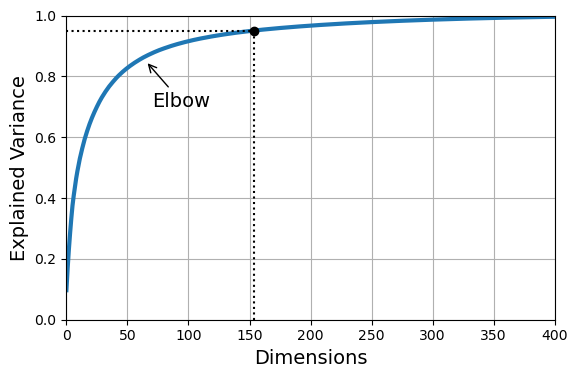

In [24]:
# Plotting cumulative explained variance 

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

## PCA for Compression

Here we are going to get those Principal Components that gather 95% of the variance and then transform the original data using them.

In [25]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [26]:
X_reduced.shape

(60000, 154)

In [27]:
X_recovered = pca.inverse_transform(X_reduced)

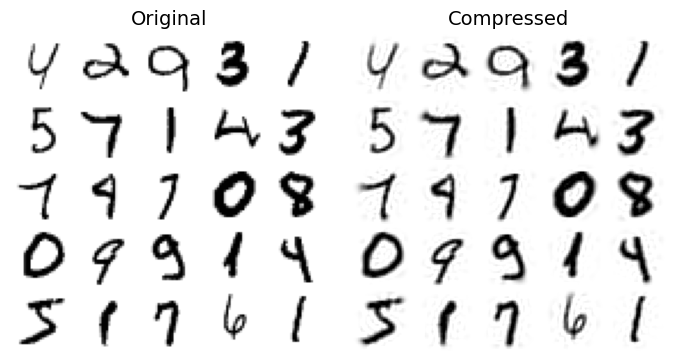

In [29]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")